# Confronto: insertion-sort vs counting-sort

Notebook pratico che confronta le prestazioni di insertion-sort e counting-sort su array di interi. Le celle alternano brevi spiegazioni (markdown) e codice eseguibile.

## Import e impostazioni
Impostiamo l'ambiente: seed riproducibile e stile per i grafici.

In [45]:
from numpy import sort
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
RNG = np.random.default_rng(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Insertion sort
Implementazione semplice (opera su una copia). Complessità: O(n^2).

In [46]:
def insertion_sort(a):
    """Ordina `a` e ritorna una nuova lista ordinata.
    Non modifica l'input."""
    if isinstance(a, np.ndarray):
        arr = a.tolist()
    else:
        arr = list(a)
    n = len(arr)
    for i in range(1, n):
        key = arr[i]
        j = i - 1
        while j >= 0 and arr[j] > key:
            arr[j+1] = arr[j]
            j -= 1
        arr[j+1] = key
    return arr

### Teoria: insertion-sort
Insertion sort è un algoritmo di ordinamento basato su confronti che può essere implementato in-place o ritornando una nuova lista.
Funzionamento: si costruisce progressivamente una porzione iniziale dell'array che è sempre ordinata; ad ogni passo si inserisce il prossimo elemento nella sua posizione corretta all'interno della porzione ordinata.

Complessità
- Caso migliore: O(n) (array già ordinato)
- Caso medio: O(n^2)
- Caso peggiore: O(n^2) (array in ordine inverso)
- Spazio addizionale: O(1) per versione in-place

Esempio rapido di `insertion_sort`.

In [47]:
sample = RNG.integers(0, 50, size=12)
print('sample:', sample)
print('insertion_sort result:', insertion_sort(sample))

sample: [ 4 38 32 21 21 42  4 34 10  4 26 48]
insertion_sort result: [4, 4, 4, 10, 21, 21, 26, 32, 34, 38, 42, 48]


## Counting sort
Counting sort per interi non negativi. Complessità: O(n + k).

In [48]:
def counting_sort(a):
    if isinstance(a, np.ndarray):
        arr = a.tolist()
    else:
        arr = list(a)
    if not arr:
        return []
    # Verifica che non ci siano valori negativi
    if min(arr) < 0:
        raise ValueError('Counting sort: supporta solo interi non negativi')
    # calcolo diretto del massimo
    max_value = max(arr)
    k = max_value + 1
    # limite di sicurezza per evitare OOM accidentali
    MAX_K_LIMIT = 50_000_000
    if k > MAX_K_LIMIT:
        raise MemoryError(f'k troppo grande per il counting sort: k={k} > {MAX_K_LIMIT}')
    counts = [0] * k
    for v in arr:
        counts[v] += 1
    out = []
    for val, c in enumerate(counts):
        if c:
            out.extend([val] * c)
    return out

### Teoria: counting-sort e varianti
- **Complessità temporale**:
  - O(n + k) in tutti i casi (migliore, medio e peggiore)
  - Non dipende dall'ordine iniziale degli elementi
  - La complessità lineare O(n) è raggiungibile solo quando k = O(n)
- **Complessità spaziale**:
  - O(n + k) totale: O(n) per l'output e O(k) per l'array di conteggio
  - Il fattore dominante è max(n, k)
  - Per k >> n diventa inefficiente in termini di memoria
- **Caratteristiche**:
  - Non basato su confronti (comparison-free)
  - Stabile nella versione con array cumulativo (non quella implementata)
  - Limitato a interi o valori mappabili a interi in un range limitato
- **Trade-off**:
  - Ottimo quando k è piccolo rispetto a n
  - Inefficiente quando k >> n (per memoria e tempo)

Esempio rapido di `counting_sort`.

In [49]:
print('counting_sort result (sample):', counting_sort(sample))

counting_sort result (sample): [4, 4, 4, 10, 21, 21, 26, 32, 34, 38, 42, 48]


## Test di correttezza
Verifica su casi semplici e edge case.

In [50]:
def is_sorted(a):
    return all(a[i] <= a[i+1] for i in range(len(a)-1))

# più test, includendo casi con ripetizioni e range piccoli/grandi
tests = [[], [1], [2,1], [5,3,8,1,2,7], list(RNG.integers(0,50,size=20)), [0,0,0,0], list(range(10,0,-1))]
for t in tests:
    res_i = insertion_sort(t)
    res_c = counting_sort(t)
    assert is_sorted(res_i)
    assert is_sorted(res_c)
    assert sorted(list(t)) == res_i == res_c
print('Tutti i test di correttezza passati.')

Tutti i test di correttezza passati.


## confronto prestazioni temporali
Misuriamo tempo medio e con deviazione standard.
Eseguiamo test su diverse combinazioni di n (dimensione) e k (massimo valore possibile)


Per valutare le prestazioni degli algoritmi di ordinamento, è necessario generare una lista di valori interi non negativi di dimensione n e misurare il tempo di esecuzione di ambedue gli algoritmi.

Per ottenere una valutazione accurata dell' Insertion Sort, verranno creati dati per il caso randomico che ha la stessa complessità del caso peggiore, e dati per il caso migliore. Invece, per il counting sort, ciò non è necessario, in quanto questi particolari dati non influiscono sulle sue prestazioni, in quanto la sua complessità resta O(n + k). I test di ordinamento verranno eseguiti su un insieme di n valori, con n che varia da 1 a 10000.

Aggiungiamo un parametro `k_exp` per definire k = n**k_exp (default 1.5).


## funzione per i test

la funzione di test valuta entrambi gli algoritmi su una copia di un array di dati e ripete il test {repeat} volte per ridurre il rumore,


In [51]:
import math
import copy
import time
def test_time_algorithm( size, repeat=5, flag_k = False, flag = False):
    ins_times = []
    count_tims = []
    if flag_k == False  :
        k = size
    else:
        k = int(round(size ** float(1.5)))
    for _ in range(repeat):

        data = data_generator(size, k)
        if flag:
            data = sort(data)
        data_insertins_sort = copy.deepcopy(data)
        t0 = time.perf_counter()
        exc = None
        try:
            insertion_sort(data_insertins_sort)
        except Exception as e:
            exc = e
        t1 = time.perf_counter()

        if exc is not None:
            ins_times.append(math.nan)
        else:

            ins_times.append(t1 - t0)
        t0 = time.perf_counter()
        try:
            counting_sort(data)

        except Exception as e:
            exc = e
        t1 = time.perf_counter()
        if exc is not None:
            count_tims.append(math.nan)
        else:

            count_tims.append(t1 - t0)

    time_np = np.array(ins_times)
    mean = np.mean(time_np)
    std = np.std(time_np)
    insertion_sort_result = {
        'mean' : mean,
        'std' : std
    }

    time_np = np.array(count_tims)
    mean = np.mean(time_np)
    std = np.std(time_np)
    counting_sort_result = {
        'mean' : mean,
        'std' : std
    }
    return insertion_sort_result, counting_sort_result

la funzione data_generator restituisce array di interi a seconda del numero di elementi e il valore massimo dei dati


In [52]:

def data_generator(size,k):
    return RNG.integers(1, k + 1, size=size, dtype=int)

la funzione di plot unica per i vari test, usa due controlli per decidere come fare il plot dei dati


In [53]:

import os
os.makedirs('noteBookPng', exist_ok=True)

def plot_results_fixed_k_vary_n(sizes: list,times_insertion, times_counting, flag_k = False, name: str = 'random', flag = False):
    """
    Crea 3 grafici:
    1. Insertion Sort con linea asintotica O(n²)
    2. Counting Sort con linea asintotica O(n + k) dove k può essere n**k_exp
    3. Confronto combinato
    """
    x = np.array(sizes, dtype=float)

    ins_mean = np.array(times_insertion['mean'], dtype=float)
    ins_std = np.array(times_insertion['std'], dtype=float)
    cnt_mean = np.array(times_counting['mean'], dtype=float)
    cnt_std = np.array(times_counting['std'], dtype=float)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, ins_mean, 'o-', label='Insertion Sort (misurato)', color='tab:blue', linewidth=2, markersize=6)
    ax.fill_between(x, ins_mean - ins_std, ins_mean + ins_std, color='tab:blue', alpha=0.2)
    if flag:
        asymptotic_insertion = x / np.max(x) * np.max(ins_mean)
        ax.plot(x, asymptotic_insertion, '--', label='O(n) asintotico', color='red', linewidth=2, alpha=0.7)
    else:
        asymptotic_insertion = (x ** 2) / np.max(x ** 2) * np.max(ins_mean)
        ax.plot(x, asymptotic_insertion, '--', label='O(n²) asintotico', color='red', linewidth=2, alpha=0.7)
    ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
    ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=11, loc='upper left')
    ax.set_ylim(bottom=0)
    if not flag_k:
        ax.set_title('Insertion Sort - Analisi Temporale', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'noteBookPng/insertion_sort_analysis_{name}.png', dpi=150)
        print("✓ Salvato: insertion_sort_analysis_{name}.png")
    else:
        ax.set_title(f'Insertion Sort con k >> n - Analisi Temporale', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'noteBookPng/insertion_sort_analysis_k_large_{name}.png', dpi=150)
        print(f"✓ Salvato: noteBookPng/insertion_sort_analysis_k_large_{name}.png")
    plt.close()

    # --- Counting plot ---
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, cnt_mean, 's-', label='Counting Sort (misurato)', color='tab:green', linewidth=2, markersize=6)
    ax.fill_between(x, cnt_mean - cnt_std, cnt_mean + cnt_std, color='tab:green', alpha=0.2)

    # Determina k_values in base a flag_k e all'esponente
    if not flag_k:
        k_values = x
    else:
        k_exp = 1.5
        k_values = x ** float(k_exp)

    # Linea asintotica O(n + k)
    X = x + k_values  # protezioni: divisione per zero
    max_X = np.max(X) if X.size > 0 else 0
    max_cnt = np.max(cnt_mean) if cnt_mean.size > 0 else 0
    if max_X == 0 or max_cnt == 0:
        asymptotic_counting = np.zeros_like(x)
    else:
        scale = max_cnt / max_X
        asymptotic_counting = X * scale
    ax.plot(x, asymptotic_counting, '--', label=f'O(n + k) asintotico ', color='red', linewidth=2, alpha=0.7)
    ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
    ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=11, loc='upper left')
    ax.set_ylim(bottom=0)

    if not flag_k:
        ax.set_title('Counting Sort - Analisi Temporale', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'noteBookPng/counting_sort_analysis_{name}.png', dpi=150)
        print(f"✓ Salvato: noteBookPng/counting_sort_analysis_{name}.png")
    else:
        ax.set_title(f'Counting Sort con k >> N - Analisi Temporale', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'noteBookPng/counting_sort_analysis_k_large_{name}.png', dpi=150)
        print(f"✓ Salvato: noteBookPng/counting_sort_analysis_k_large_{name}.png")
    plt.close()

    # ===== Grafico 3: Confronto combinato =====
    fig, ax = plt.subplots(figsize=(12, 7))
    # Plot Insertion Sort
    ax.plot(x, ins_mean, 'o-', label='Insertion Sort', color='tab:blue', linewidth=2.5, markersize=7)
    ax.fill_between(x, ins_mean - ins_std, ins_mean + ins_std, color='tab:blue', alpha=0.15)

    # Plot Counting Sort
    ax.plot(x, cnt_mean, 's-', label='Counting Sort', color='tab:green', linewidth=2.5, markersize=7)
    ax.fill_between(x, cnt_mean - cnt_std, cnt_mean + cnt_std, color='tab:green', alpha=0.15)

    # Linea asintotica Counting Sort per il confronto
    if not flag_k:
        k_values = x
    else:
        k_values = x ** float(k_exp)
    X = x + k_values
    max_X = np.max(X) if X.size > 0 else 0
    max_cnt = np.max(cnt_mean) if cnt_mean.size > 0 else 0.0
    if max_X == 0 or max_cnt == 0:
        asymptotic_counting = np.zeros_like(x)
    else:
        scale = max_cnt / max_X
        asymptotic_counting = X * scale

    if flag_k:
        ax.plot(x, asymptotic_counting, '--', label=f'O(n + k) asintotico ', color='red', linewidth=2, alpha=0.7)

    ax.set_xlabel('Dimensione dell\'array (n)', fontsize=12)
    ax.set_ylabel('Tempo di esecuzione (s)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=11, loc='upper left', ncol=2)
    ax.set_ylim(bottom=0)

    # Salvataggio del grafico di confronto: scegli il nome di file appropriato
    if not flag_k or name != 'random' :
        ax.set_title('Confronto: Insertion Sort vs Counting Sort', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'noteBookPng/sorting_comparison_{name}.png', dpi=150)
        print(f"✓ Salvato: noteBookPng/sorting_comparison_{name}.png")
    else:
        ax.set_title(f'Confronto con k = n^{k_exp}: Insertion Sort vs Counting Sort', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'noteBookPng/sorting_comparison_k_large_{name}.png', dpi=150)
        print(f"✓ Salvato: noteBookPng/sorting_comparison_k_large_{name}.png")
    plt.close()



## Test su casi con k contenuto, k = n, il k che viene passato come parametro è da moltiplicare per n, e dati casuali

In [54]:
sizes = np.round(np.linspace(1, 10000, 20)).astype(int)

def confronto_insertion_counting(sizes = sizes,flag_k= False, name = 'random'):
    ins_sort_result = {
        'mean' : [],
        'std' : []
    }
    counting_sort_result = {
        'mean' : [],
        'std' : []
    }
    if name != 'random' :
        flag = True
    else:
        flag = False
    for i in sizes:
        print('i:', i)
        temp_ins, temp_count = test_time_algorithm(size=i, flag_k= flag_k, flag = flag)
        ins_sort_result['mean'].append( temp_ins['mean'])
        ins_sort_result['std'].append( temp_ins['std'])
        counting_sort_result['mean'].append( temp_count['mean'])
        counting_sort_result['std'].append( temp_count['std'])

    plot_results_fixed_k_vary_n(sizes= sizes ,times_insertion=ins_sort_result, times_counting= counting_sort_result, name = name ,flag = flag, flag_k= flag_k)


confronto_insertion_counting(sizes = sizes, flag_k= False, name = 'random')

i: 1
i: 527
i: 1054
i: 1580
i: 2106
i: 2632
i: 3159
i: 3685
i: 4211
i: 4737
i: 5264
i: 5790
i: 6316
i: 6842
i: 7369
i: 7895
i: 8421
i: 8947
i: 9474
i: 10000
✓ Salvato: insertion_sort_analysis_{name}.png
✓ Salvato: noteBookPng/counting_sort_analysis_random.png
✓ Salvato: noteBookPng/sorting_comparison_random.png


## Test con k molto grande rispetto a n riusando vecchie strutture

In [55]:
confronto_insertion_counting(sizes = sizes,flag_k= True, name = 'random')

i: 1
i: 527
i: 1054
i: 1580
i: 2106
i: 2632
i: 3159
i: 3685
i: 4211
i: 4737
i: 5264
i: 5790
i: 6316
i: 6842
i: 7369
i: 7895
i: 8421
i: 8947
i: 9474
i: 10000
✓ Salvato: noteBookPng/insertion_sort_analysis_k_large_random.png
✓ Salvato: noteBookPng/counting_sort_analysis_k_large_random.png
✓ Salvato: noteBookPng/sorting_comparison_k_large_random.png


## Il test esegue test su set di dati ordinati per il caso migliore del selection con k contenuta e stampa i test risultanti


In [56]:
#plot_results_fixed_k_vary_n(sizes= sizes ,times_insertion=selectionSort1, times_counting=countingSort1 , flag_k=True, name = 'random')

In [57]:
confronto_insertion_counting(sizes = sizes, flag_k= False, name = 'best_case')

i: 1
i: 527
i: 1054
i: 1580
i: 2106
i: 2632
i: 3159
i: 3685
i: 4211
i: 4737
i: 5264
i: 5790
i: 6316
i: 6842
i: 7369
i: 7895
i: 8421
i: 8947
i: 9474
i: 10000
✓ Salvato: insertion_sort_analysis_{name}.png
✓ Salvato: noteBookPng/counting_sort_analysis_best_case.png
✓ Salvato: noteBookPng/sorting_comparison_best_case.png


## Il test esegue test su set di dati ordinati per il caso migliore del selection con k contenuta e stampa i test risultanti


In [58]:
#confronto_insertion_counting(sizes = sizes, k = 5000, name = 'best_case', f2 = True)

sizes = np.round(np.linspace(1, 10000, 20)).astype(int).## Visualizzazione grafici

### Confronto per k=n random

| Immagine 1 | Immagine 2 |
|---|---|
| ![Grafico 1](noteBookPng/insertion_sort_analysis_random.png) | ![Grafico 2](noteBookPng/counting_sort_analysis_random.png) |


 ![Grafico 3](noteBookPng/sorting_comparison_random.png)

Conclusione sintetica:
- Quando k = n e i dati sono casuali, il Counting Sort mostra comportamento lineare con n mentre l'Insertion Sort cresce molto più velocemente (quadraticamente). Nel grafico di confronto `sorting_comparison_random.png` si osserva chiaramente che Counting Sort è più efficiente per le dimensioni mostrate.

Perché succede:
- Counting Sort ha costo O(n + k) e qui k = n ⇒ O(2n) = O(n) in pratica lineare.
- Insertion Sort ha costo medio O(n²) e quindi scala peggio per n grandi.

### Confronto per k = n^1.5 (esempio)

| Immagine 1 | Immagine 2 |
|---|---|
| ![Grafico 1](noteBookPng/insertion_sort_analysis_k_large_random.png) | ![Grafico 2](noteBookPng/counting_sort_analysis_k_large_random.png) |

 ![Grafico 3](noteBookPng/sorting_comparison_k_large_random.png)

Conclusione sintetica:
- Se k cresce come n^1.5 (cioè k = n^1.5), il termine O(k) nel counting-sort diventa O(n^1.5) e la complessità del counting-sort è O(n + n^1.5) ~ O(n^1.5). L'insertion-sort rimane O(n^2). Per valori piccoli o moderati di n il confronto dipende da costanti pratiche e overhead; per n molto grandi l'insertion-sort sarà asintoticamente peggiore (O(n^2)), ma il counting-sort può risultare più costoso del semplice caso k=O(n) a causa del termine k.

Perché succede:
- Counting Sort deve allocare e processare un array di dimensione k: l'allocazione e l'iterazione sull'array di conteggio impongono un costo che cresce con k (qui ~n^1.5).
- L'Insertion Sort non dipende da k; per valori di n in cui n^1.5 è dominante, il counting-sort può avere tempi significativamente maggiori rispetto al caso k=O(n).

### Confronto per k=n sorted

| Immagine 1 | Immagine 2 |
|---|---|
| ![Grafico 1](noteBookPng/insertion_sort_analysis_best_case.png) | ![Grafico 2](noteBookPng/counting_sort_analysis_best_case.png) |


 ![Grafico 3](noteBookPng/sorting_comparison_best_case.png)

Conclusione sintetica:
- Se i dati sono già ordinati e k = n, l'Insertion Sort mostra il suo caso migliore O(n) e può competere o addirittura superare Counting Sort per alcune dimensioni (soprattutto per n non troppo grandi). Tuttavia Counting Sort rimane comunque O(n + k) e non beneficia dell'ordine iniziale.

Perché succede:
- L'Insertion Sort nel caso migliore richiede solo scansioni semplici e spostamenti minimi → O(n).
- Counting Sort non beneficia dell'ordine iniziale (la sua complessità rimane O(n + k)) e quindi il vantaggio dell'Insertion è visibile quando il caso migliore applica.


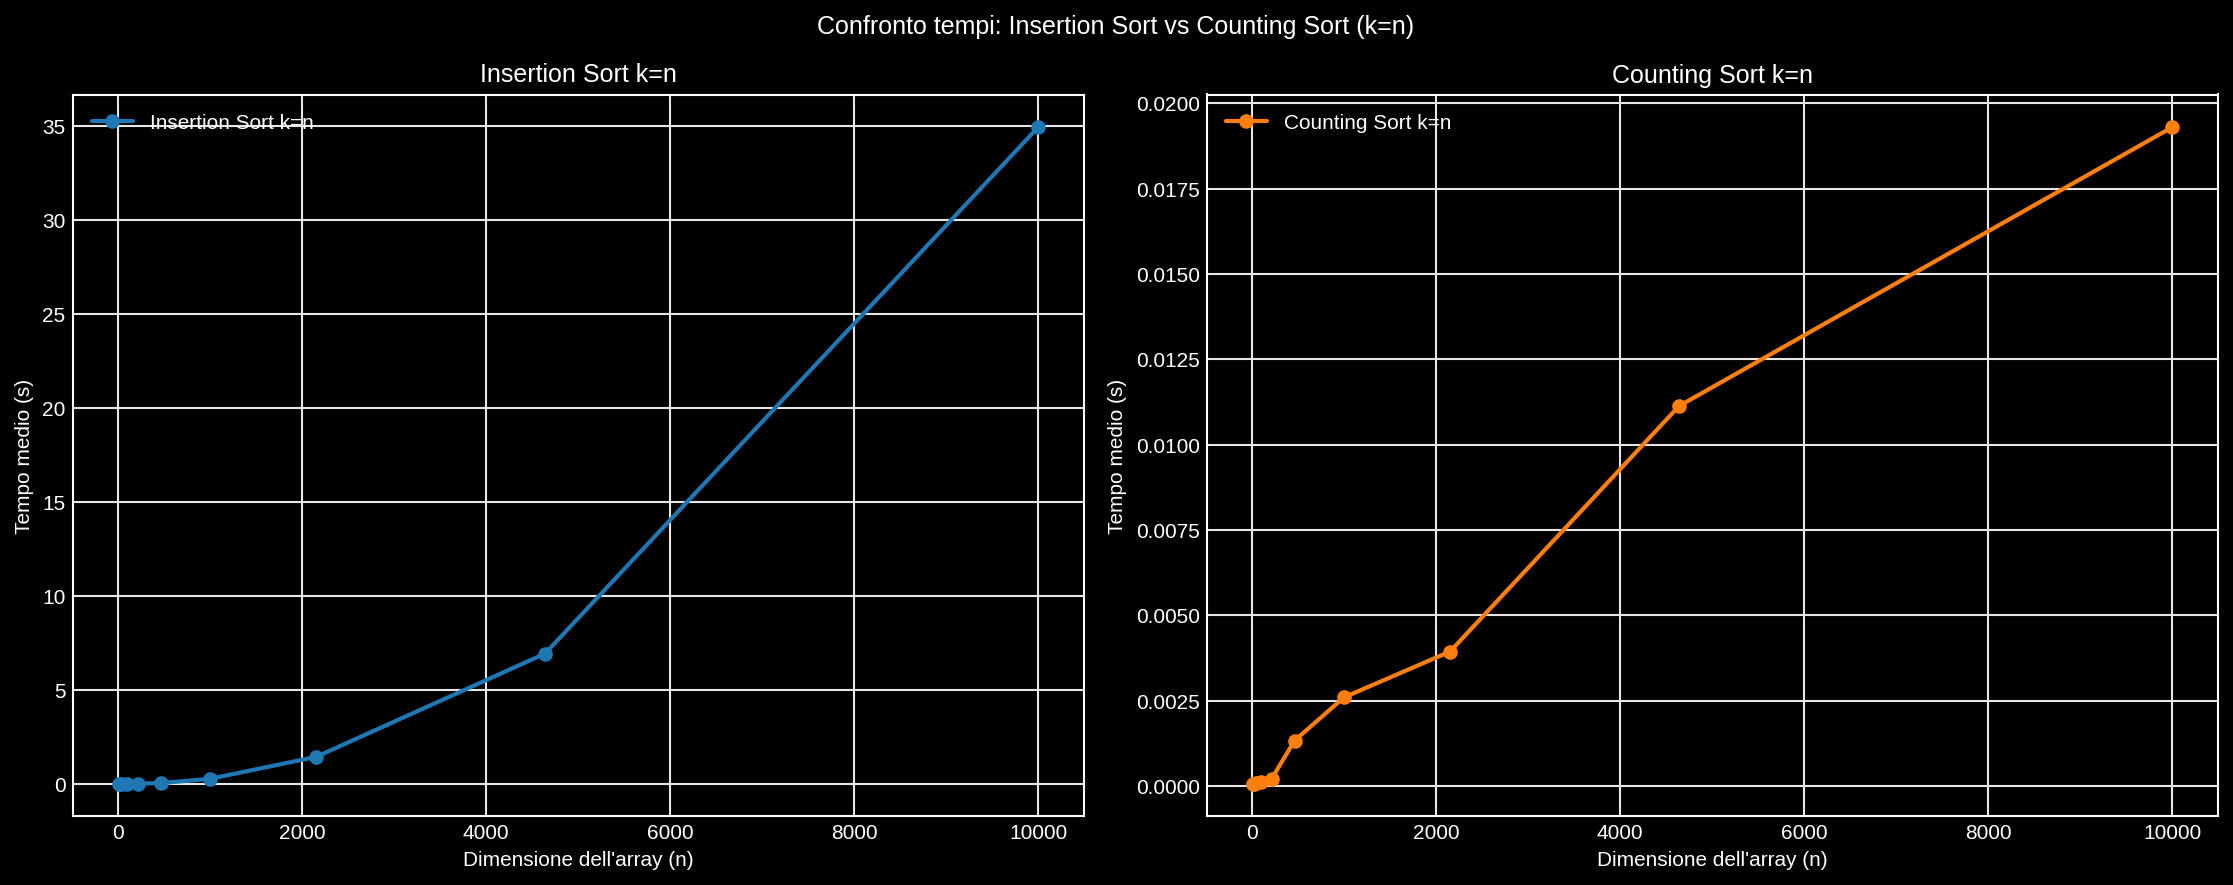
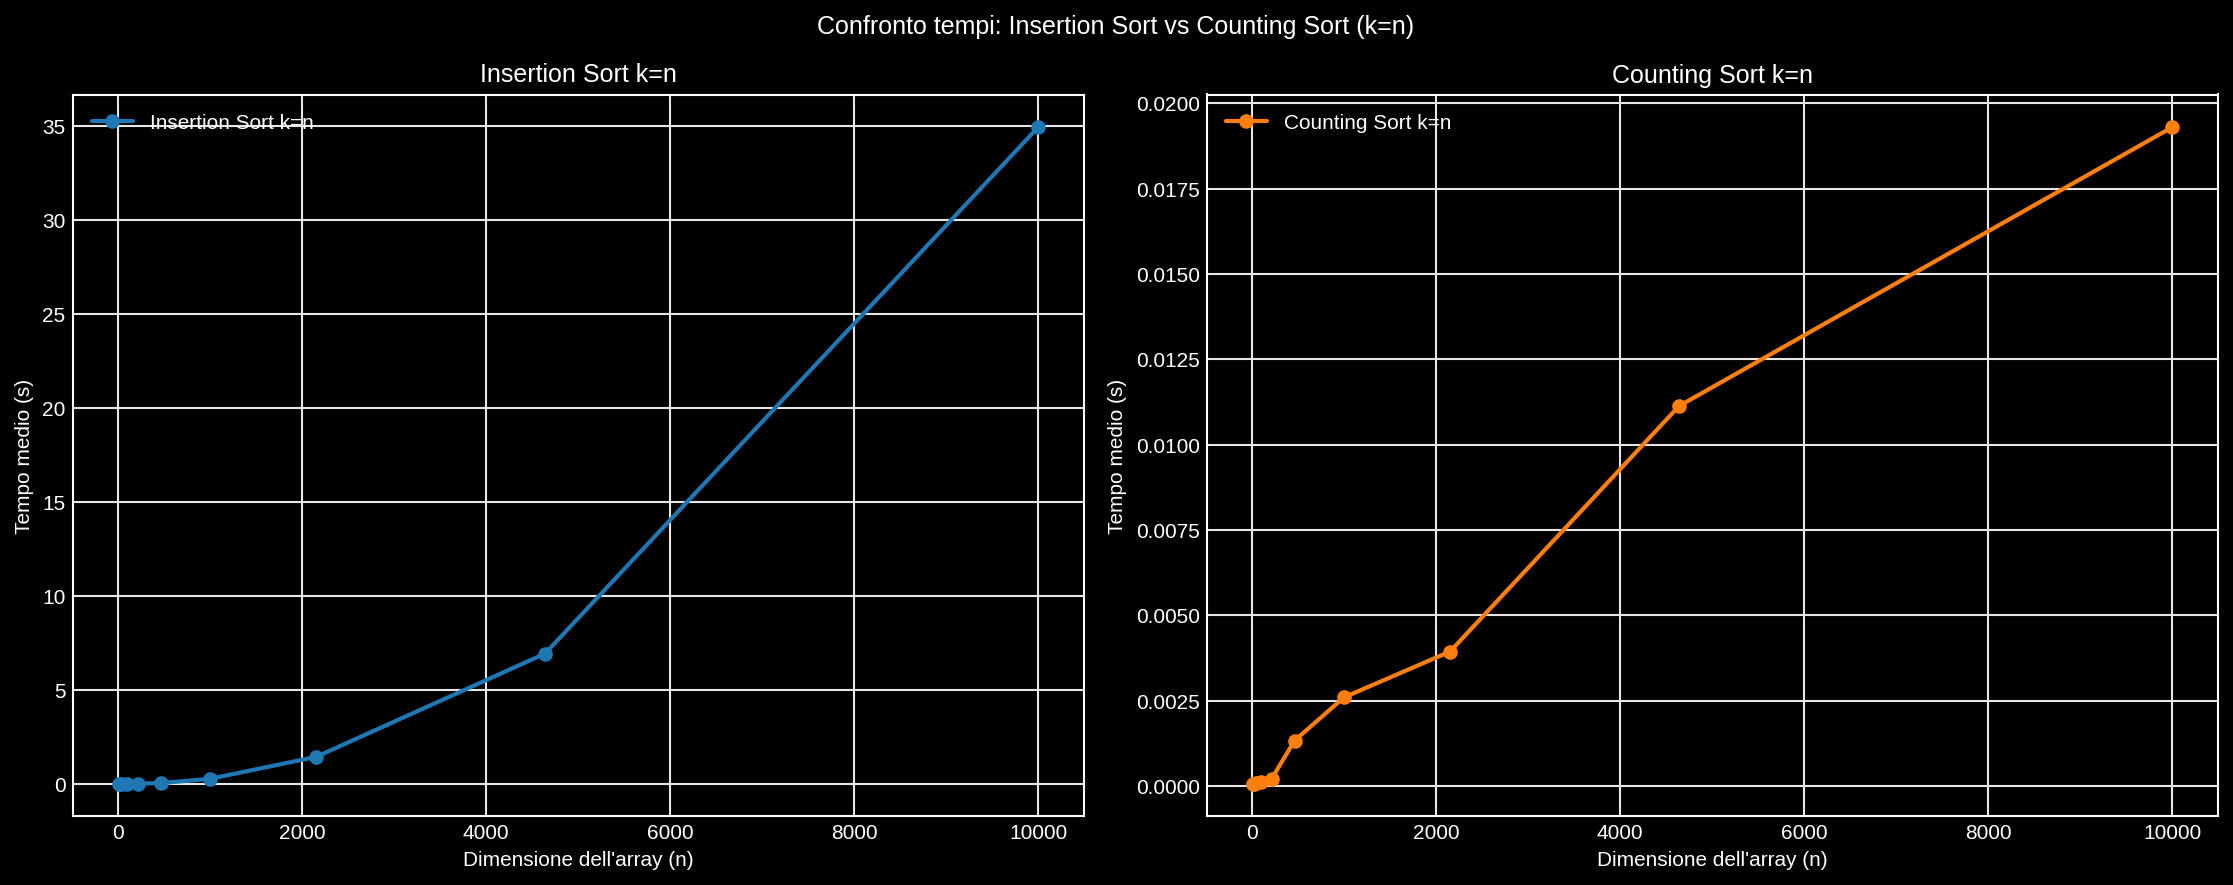
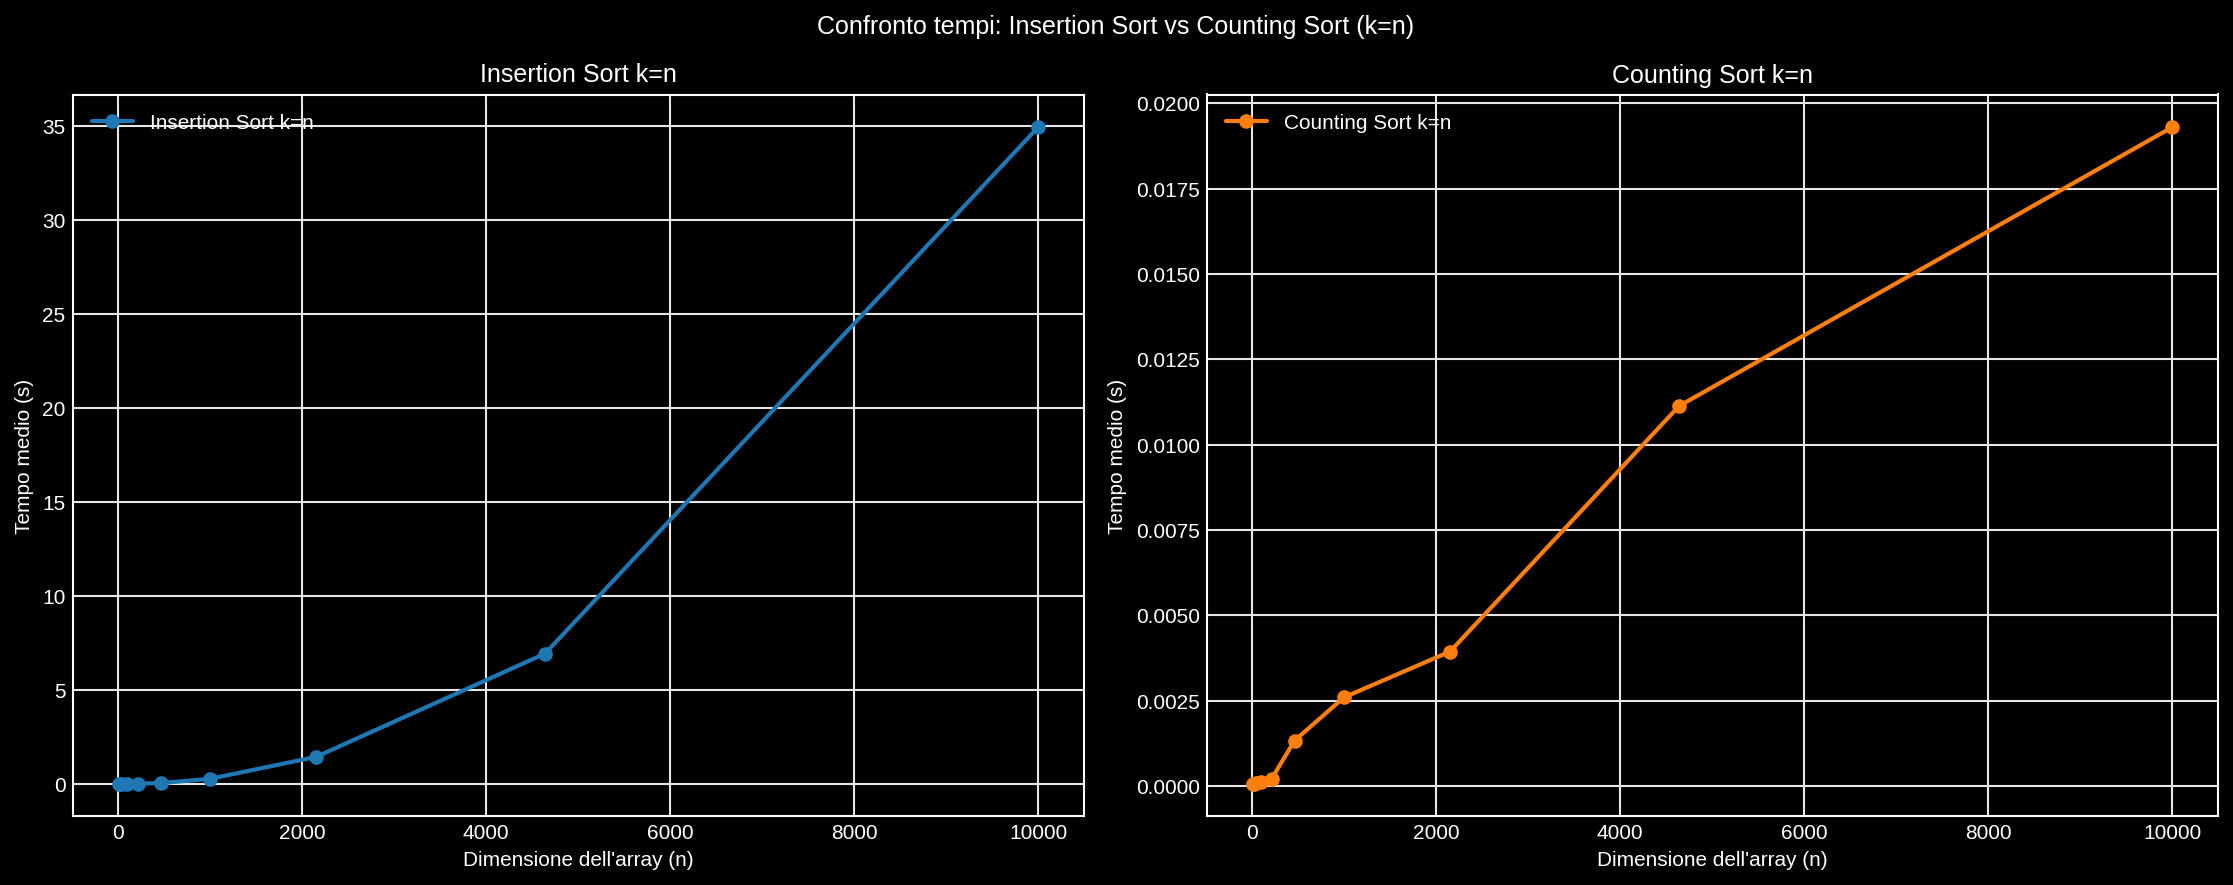
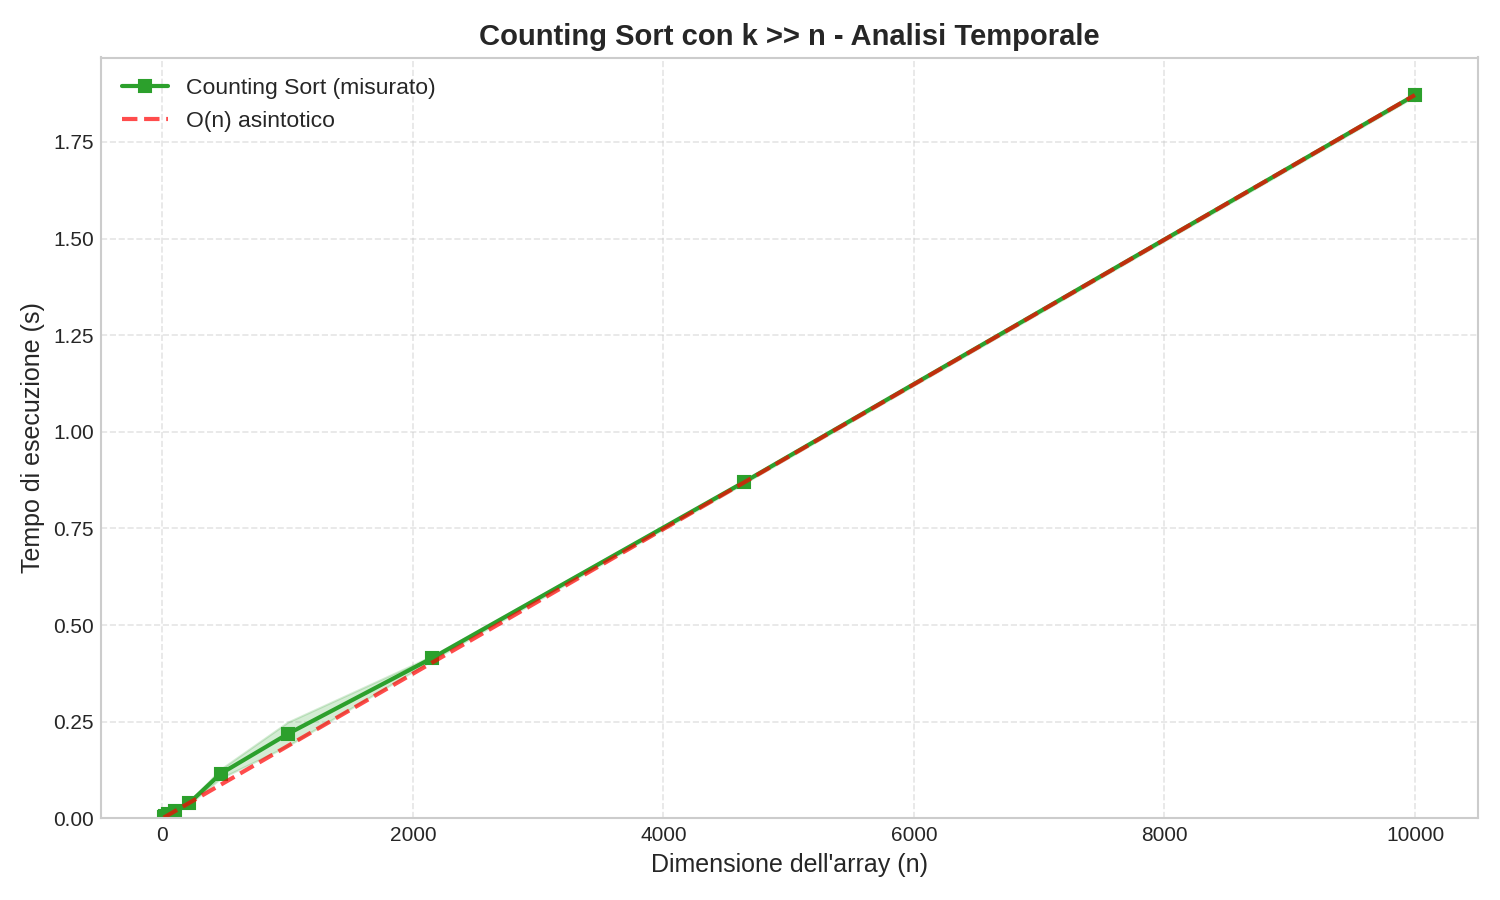
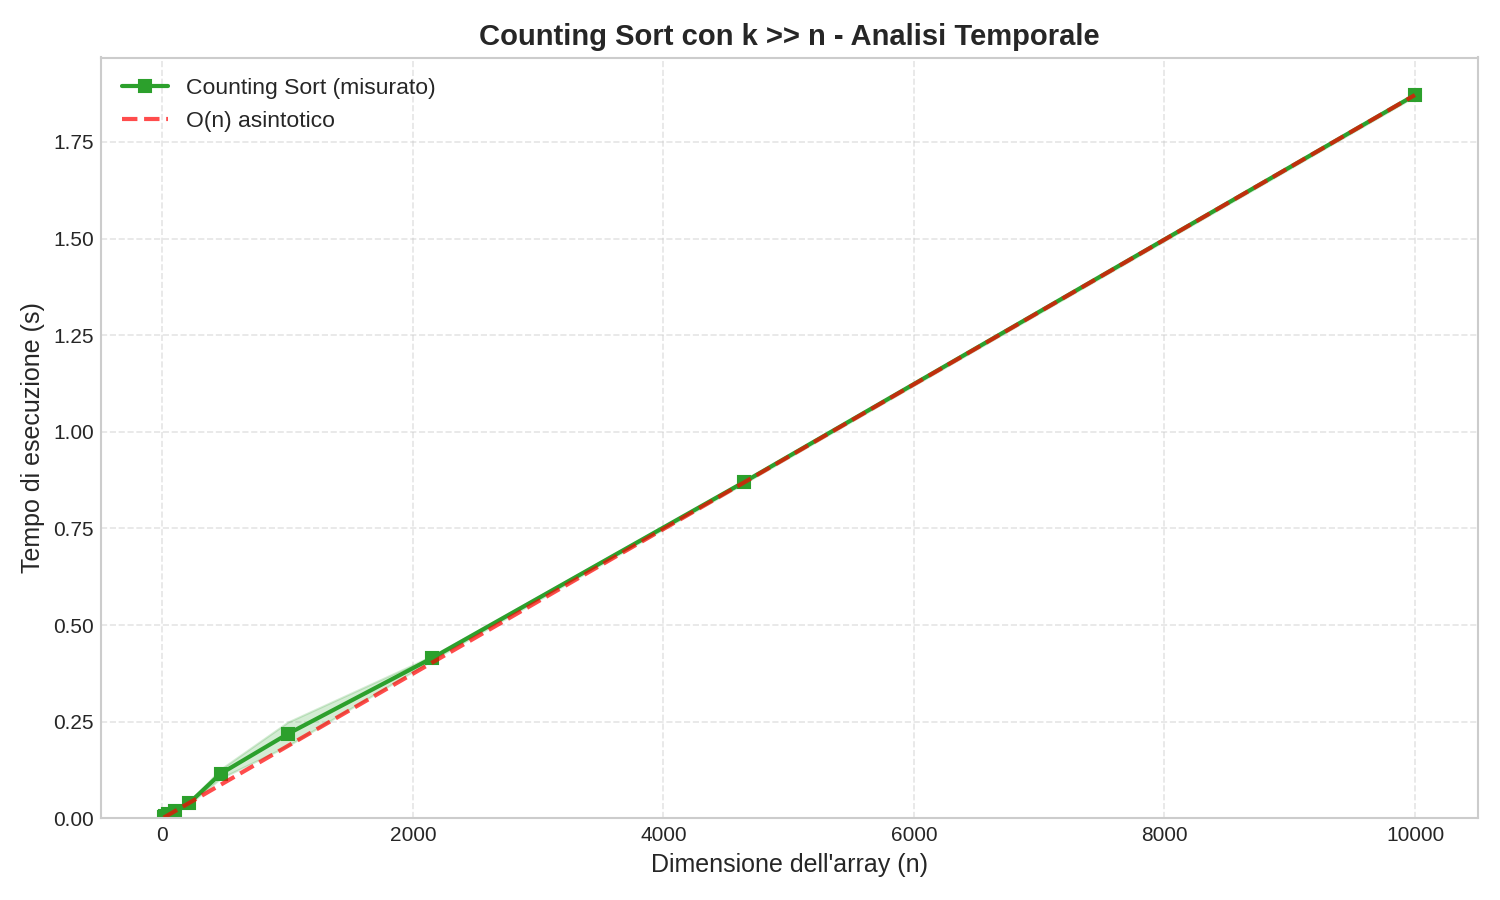
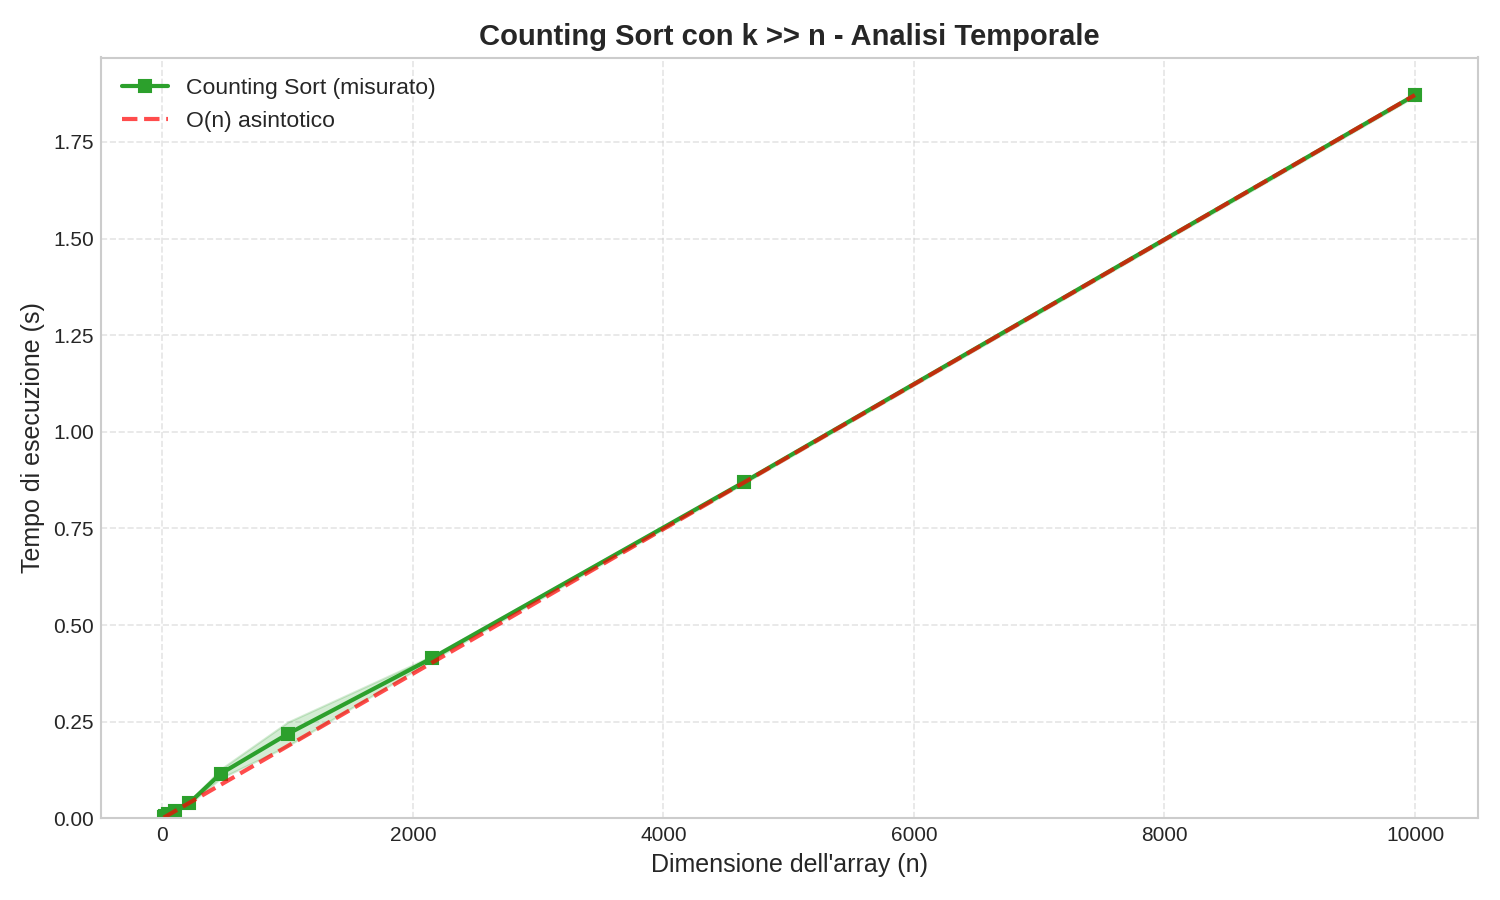
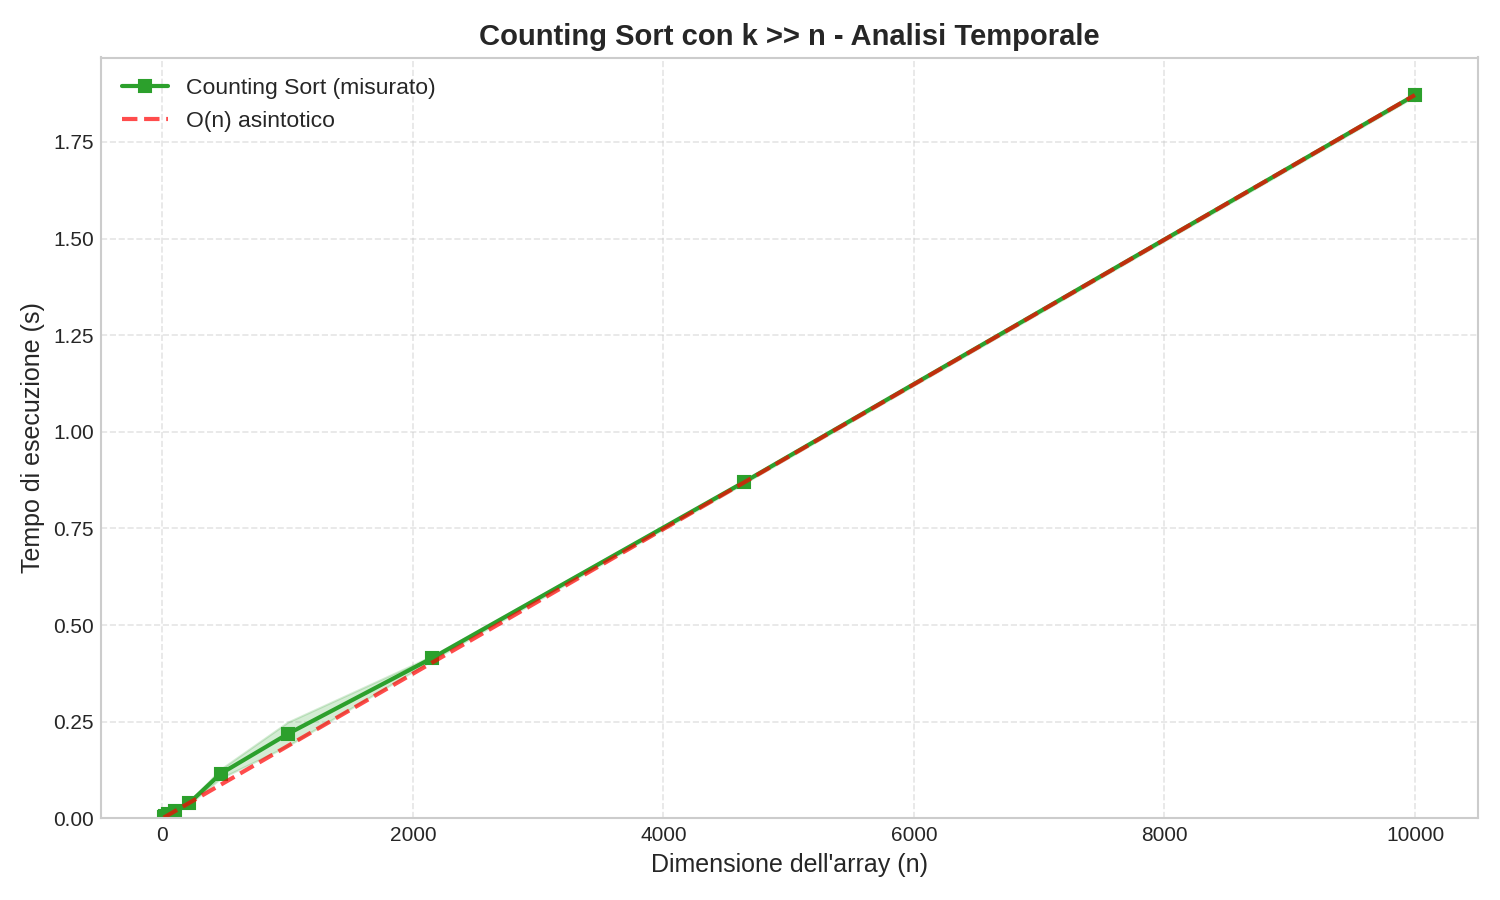

## Teoria: benchmarking e misurazioni


- **Perché il warmup**:
  - Negli ambienti Python, la prima esecuzione di una funzione è spesso più lenta (compilazione JIT, cache, ottimizzazioni interne)
  - Il warmup prepara l'interprete e le strutture dati interne per misurazioni più stabili
  - Neutralizza effetti come: inizializzazione lazy, compilazione JIT (per PyPy), ottimizzazioni del GC, ecc.
  - In questo esperimento, eseguiamo insertion_sort e counting_sort su un array di test prima di iniziare le misurazioni reali

- **Metodologia di misurazione**:
  - Ripetizione multipla: ogni misura è ripetuta 5 volte per ottenere valori statisticamente significativi usando set di dati differenti
  - Calcolo di media e deviazione standard: per valutare sia le prestazioni tipiche che la loro variabilità

## Conclusioni: analisi comparativa e risorse utilizzate

### Complessità teorica
- **Insertion sort**:
  - Tempo: O(n²) in generale, O(n) nel caso migliore (array già ordinato)
  - Spazio: O(1) addizionale per la versione in-place

- **Counting sort**:
  - Tempo: O(n + k) in tutti i casi
  - Spazio: O(n + k) totale, con O(k) per l'array di conteggio

### Osservazioni empiriche
- **Risorse temporali**:
  - L'insertion sort diventa rapidamente inefficiente al crescere di n (confermando la complessità quadratica)
  - Il counting sort mantiene prestazioni lineari quando k è contenuto
  - Per k molto grande rispetto a n, il counting sort perde il suo vantaggio competitivo

- **Risorse di memoria**:
  - L'insertion sort ha un consumo di memoria proporzionale alla dimensione dell'input (O(n))
  - Il counting sort richiede memoria aggiuntiva significativa per l'array dei conteggi (O(k))
  - Per valori di k molto grandi (k >> n), il counting sort può diventare proibitivo in termini di memoria

### Applicazioni pratiche
- **Quando usare insertion sort**:
  - Array piccoli (n < 10-20)
  - Array quasi ordinati
  - Quando la memoria è una risorsa critica

- **Quando usare counting sort**:
  - Range di valori limitato e noto (k = O(n))
  - Grandi dataset con valori ripetuti in un intervallo ristretto
  - Quando la velocità è prioritaria rispetto alla memoria
  - Come componente di algoritmi più sofisticati (es. radix sort)

In conclusione, la scelta tra insertion sort e counting sort dipende criticamente dal rapporto tra n (dimensione dell'input) e k (range dei valori), oltre che dalle risorse di sistema disponibili e dai requisiti dell'applicazione.
